# Hydrology Data

In [1]:
from __future__ import annotations

import math
from pathlib import Path
from urllib.parse import urlencode

import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import rioxarray.merge as rio_merge

import tiny_retriever as terry

In this tutorial, we learn how we can make queries to web service APIs that provide hydrology data. We will use the [USGS Water Services](https://waterservices.usgs.gov/) and [USGS 3DEP](https://www.usgs.gov/3d-elevation-program) APIs to get data on water resources and elevation data, respectively.

For this tutorial, we use `geopandas` and `rioxarray` to handle the data and use TinyRetriever to make the API requests.

Let's start by getting the watershed boundary for the Lower Duck River in Tennessee, USA. We directly pass the boundary GeoJson from [GeoConnex](https://geoconnex.us/) web service to `geopandas` to get the boundary.

In [2]:
huc8 = "06040003"
duck = gpd.read_file(f"https://reference.geoconnex.us/collections/hu08/items/{huc8}")

Skipping field hucs: unsupported OGR type: 5


First, we use 3DEP's API to get the elevation data for the watershed. This web service provides a REST API to get the elevation data for a given bounding box. However, the API has a limit on the number pixels per request. We will split the bounding box into smaller parts and make multiple requests to get the elevation data. For this purpose, we set the maximum number of pixels per request to 8 million then break down the bounding box into equal-area smaller bounding boxes. This is actually what [Seamless3DEP](https://seamless-3dep.readthedocs.io/en/latest/) does under the hood.

Additionally, we need to generate file names for these sub-bounding boxes to save the data. TinyRetriever has a nice little utility function that generates unique filenames based on a web query by using SHA256 hash. We will use this function to generate file names for the elevation data.

In [3]:
save_dir = Path("data")
save_dir.mkdir(exist_ok=True)
res = 10
base_url = (
    "https://elevation.nationalmap.gov/arcgis/rest/services/3DEPElevation/ImageServer/exportImage"
)
pixel_max = 8_000_000

xmin, ymin, xmax, ymax = duck.to_crs(5070).total_bounds
width = math.ceil((xmax - xmin) / res)
height = math.ceil((ymax - ymin) / res)
aspect_ratio = width / height
n_boxes = math.ceil((width * height) / pixel_max)
nx = math.ceil(math.sqrt(n_boxes * aspect_ratio))
ny = math.ceil(n_boxes / nx)

west, south, east, north = duck.to_crs(4326).total_bounds.round(6)
dx = (east - west) / nx
dy = (north - south) / ny
sub_width = math.ceil(width / nx)
sub_height = math.ceil(height / ny)

url_list = []
tiff_list = []
for i in range(nx):
    box_west = west + (i * dx)
    box_east = min(west + ((i + 1) * dx), east)
    for j in range(ny):
        box_south = south + (j * dy)
        box_north = min(south + ((j + 1) * dy), north)
        params = {
            "bbox": f"{box_west},{box_south},{box_east},{box_north}",
            "bboxSR": 4326,
            "imageSR": 3857,
            "size": f"{sub_width},{sub_height}",
            "format": "tiff",
            "interpolation": "RSP_BilinearInterpolation",
            "f": "image",
        }
        url_list.append(f"{base_url}?{urlencode(params)}")
        dem_tif = terry.unique_filename(
            base_url, params=params, prefix="dem_", file_extension="tif"
        )
        dem_tif = save_dir / dem_tif
        tiff_list.append(dem_tif)
print(f"Number of tiles: {len(url_list)}")

Number of tiles: 12


We can see that by doing so, we generated 12 bounding boxes, covering the entire watershed which has an area of around 4000 square kilometers. We then make a request to the 3DEP API for each of these bounding boxes and merge the data to get the elevation data for the entire watershed.

After generating the queries and filenames, we use `terry.download` to download the GeoTIFF files. Note that this function has an argument called `raise_status` which by default is set to `True`. This means that if the status code of the response for one of the requests is not 200, the function will raise an exception and stops downloading the remaining files. We can, however, set this false so it will continue downloading the remaining files, but we have to check which files were not downloaded.

In [4]:
terry.download(url_list, tiff_list, raise_status=False)
failed = [f for f in tiff_list if not f.exists()]
if failed:
    print(f"Failed to download {len(failed)} tiles.")
else:
    print("All tiles downloaded successfully.")

All tiles downloaded successfully.


We see that all the files were downloaded successfully. We then use `rioxarray` to open the files and merge them to get the elevation data for the entire watershed.

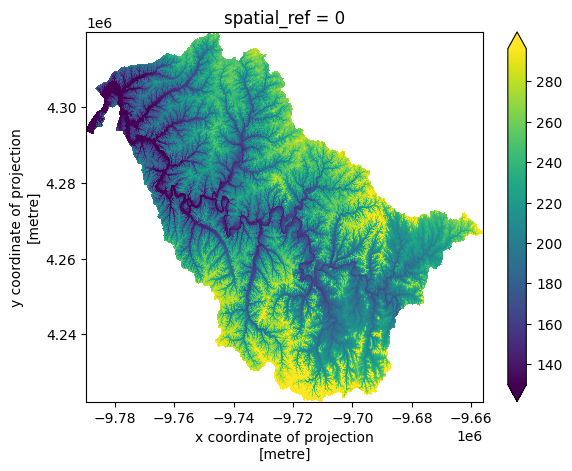

In [5]:
dem = rio_merge.merge_arrays([rxr.open_rasterio(f) for f in tiff_list]).squeeze(drop=True)
dem = dem.rio.clip_box(*duck.total_bounds, crs=duck.crs).rio.clip([duck.union_all()], crs=duck.crs)
ax = dem.plot.imshow(robust=True)
ax.figure.savefig("images/dem.png")

Next, we get all USGS stations within the Lower Duck River watershed. We use the USGS Water Services API to get the stations. You can explore the API documentation [here](https://waterservices.usgs.gov/test-tools/?service=site). Note that we use RDB as return format so we can use `pandas` to handle the data. We query stations that have daily streamflow data between 2010 and 2020 and are still active.

In [6]:
base_url = "https://waterservices.usgs.gov/nwis/site"
params = {
    "format": "rdb",
    "huc": f"{huc8}",
    "startDT": "2010-05-10",
    "endDT": "2020-05-10",
    "siteStatus": "active",
    "parameterCd": "00060",
    "hasDataTypeCd": "dv",
    "outputDataTypeCd": "dv",
}
resp = terry.fetch(base_url, "text", request_kwargs={"params": params})
data = [line.split("\t") for line in resp.splitlines() if not line.startswith("#")]
stations = pd.DataFrame.from_dict(dict(zip(data[0], d)) for d in data[2:])
print(f"Found {len(stations.site_no.unique())} stations")

Found 5 stations


We found 5 stations that meet the criteria. We then query the [Daily Value](https://waterservices.usgs.gov/test-tools/?service=dv) endpoint of the API to get the streamflow data for these stations. We use the same approach as before to download the data and merge it to get the streamflow data for the entire watershed.

In [7]:
station_ids = stations.loc[stations.alt_va.astype("f4") > 400, "site_no"].unique()
base_url = "https://waterservices.usgs.gov/nwis/dv/"

params = {
    "format": "json",
    "sites": ",".join(station_ids),
    "startDT": "2010-05-10",
    "endDT": "2020-05-10",
    "siteStatus": "active",
    "parameterCd": "00060",
}
resp = terry.fetch(base_url, "json", request_kwargs={"params": params})

Finally, we plot the elevation data and streamflow data for the watershed.

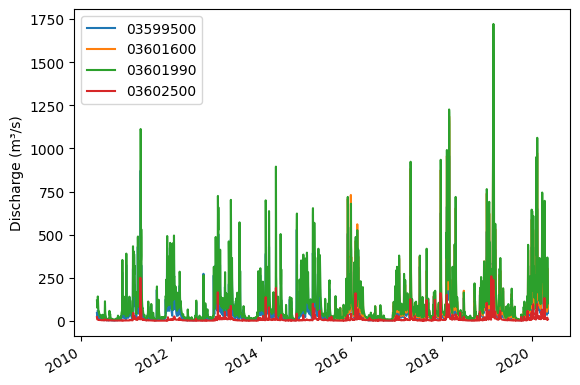

In [8]:
data = resp["value"]["timeSeries"]
tz = data[0]["sourceInfo"]["timeZoneInfo"]
qobs = []
for series in data:
    values = series["values"][0]["value"]
    discharge = pd.DataFrame.from_records(values, exclude=["qualifiers"], index=["dateTime"])
    # convert to cubic meters per second
    discharge["value"] = pd.to_numeric(discharge["value"], errors="coerce") * 0.3048**3
    # convert to UTC
    time_zone = {
        "CST": "US/Central",
        "MST": "US/Mountain",
        "PST": "US/Pacific",
        "EST": "US/Eastern",
    }.get(
        tz["defaultTimeZone"]["zoneAbbreviation"],
        tz["defaultTimeZone"]["zoneAbbreviation"],
    )
    discharge.index = pd.DatetimeIndex(
        pd.Timestamp(i, tz=time_zone) for i in discharge.index
    ).tz_convert("UTC")
    # rename the column to the site number
    discharge.columns = [series["sourceInfo"]["siteCode"][0]["value"]]
    qobs.append(discharge)
qobs = pd.concat(qobs, axis=1)
_ = qobs.plot(ylabel="Discharge (m³/s)")